## Pharmaceutical Sales prediction across multiple stores 

### Using Machine Learning and Deep Learning approaches to predict Pharmaceutical store(s) sales depending on factors such as promotions, competition, school and state holidays, seasonality, and locality as necessary for predicting the sales across the various stores

## Part 01. Exploration of customer purchasing behavior

## 1.1 Promotion Distribution of data in both training and test sets.

- Importing Neccessary packages and Lading data

In [18]:
# Importing Neccessary packages
import sys, os
import json
import requests
import time
import datetime as dt
from datetime import date, timedelta, datetime

from itertools import repeat
import itertools

import numpy as np
import pandas as pd
import statistics as st
import scipy.stats as ss
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

In [19]:
# Loading the Data
data=pd.read_csv('../data/AdSmartABdata.csv')
data.head()

auction_id experiment        date  hour  \
0  0008ef63-77a7-448b-bd1e-075f42c55e39    exposed  2020-07-10     8   
1  000eabc5-17ce-4137-8efe-44734d914446    exposed  2020-07-07    10   
2  0016d14a-ae18-4a02-a204-6ba53b52f2ed    exposed  2020-07-05     2   
3  00187412-2932-4542-a8ef-3633901c98d9    control  2020-07-03    15   
4  001a7785-d3fe-4e11-a344-c8735acacc2c    control  2020-07-03    15   

          device_make  platform_os                browser  yes  no  
0  Generic Smartphone            6          Chrome Mobile    0   0  
1  Generic Smartphone            6          Chrome Mobile    0   0  
2               E5823            6  Chrome Mobile WebView    0   1  
3   Samsung SM-A705FN            6               Facebook    0   0  
4  Generic Smartphone            6          Chrome Mobile    0   0

In [20]:
# Exploring Data types of a given data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


### The dataset has no missing Values, each column has 8077 entries

In [21]:
# Showing how many responded yes or no in both group
print(pd.crosstab(data['experiment'], data['yes']))
print("-----------------")
print(pd.crosstab(data['experiment'], data['no']))

yes            0    1
experiment           
control     3807  264
exposed     3698  308
-----------------
no             0    1
experiment           
control     3749  322
exposed     3657  349


### Counting Users who belong to Control and Exposed Groups

 control group has a total users of 4071
 exposed group has a total users of 4006


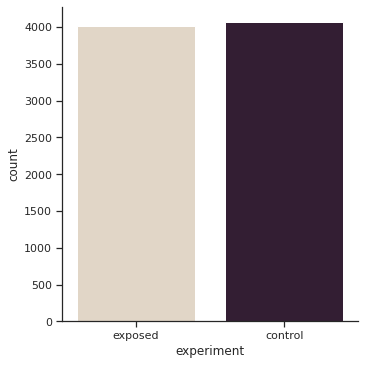

In [22]:
# Out of Total Users, how many belongs the control and Exposed
categories = ["control", "exposed"]
for category in categories:
    print(f" {category} group has a total users of {data[data.experiment == category].experiment.count()}")


sns.catplot(x="experiment", kind="count", palette="ch:.25", data=data)


The Groups contains Almost the same number of users

In [23]:
#  Plotting functions
def plot_bar(df:pd.DataFrame, x_col:str, y_col:str, title:str, xlabel:str, ylabel:str)->None:
    plt.figure(figsize=(12, 7))
    sns.barplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.show()

def plot_hist(df:pd.DataFrame, column:str, color:str)->None:
    sns.displot(data=df, x=column, color=color, kde=True, height=4, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

### There are 4071 Control group users and 4006 exposed group users

### Counting the Users who responded and who doesn't

 Users that never Responded: 6834 
 Users that have  Ambigous Response - answered 1 in both 'yes', and 'no': 0
 Users that  Responded: 1243 which is 15.39 % of the total Uses


<ipython-input-24-f34fac6eb99c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_response = data[data.no ==0][data.yes ==0].auction_id.count()
<ipython-input-24-f34fac6eb99c>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ambigous_response = data[data.no ==1][data.yes ==1].auction_id.count()


<AxesSubplot:ylabel='None'>

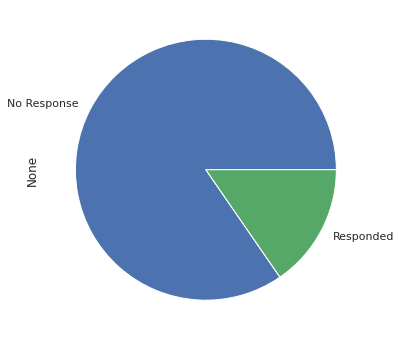

In [24]:
no_response = data[data.no ==0][data.yes ==0].auction_id.count()
ambigous_response = data[data.no ==1][data.yes ==1].auction_id.count()
total_users = data.auction_id.count()
users_responded = total_users-no_response
# f" There are {loaded_data.shape[0]} rows and {loaded_data.shape[1]} columns of Telecom Users Data"
print(f" Users that never Responded: {no_response} ")
print(f" Users that have  Ambigous Response - answered 1 in both 'yes', and 'no': {ambigous_response}")
print(f" Users that  Responded: {users_responded} which is {round((users_responded/total_users)*100,2)} % of the total Uses")

series = pd.Series([no_response, ambigous_response,users_responded], 
                   index=["No Response","Ambigous Response", "Responded"])
series.plot.pie(figsize=(6, 6))

### The Users Responded to the Ad is 15.39%, and users that didn't respond is 84.61% to the total Users

### Checking if there are same users in multiple rows

In [25]:
unique_users = data['auction_id'].unique()
print(len(unique_users))

8077


### Making Dataset that contains Users who Responded, Droping Users who didn't Respond and Saving as CSV

In [224]:
# index_to_drop = data[(data['yes']==0) & (data['no']==0)].index
# # # Delete these row indexes from dataFrame

# data.drop(index_to_drop , inplace=True)
# # print(index_to_drop)
# data.to_csv('../data/Resp_dataSet.csv', index=False)

In [107]:
#  Loading data with users response
resp_data=pd.read_csv('../data/Resp_dataSet.csv')
resp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   1243 non-null   object
 1   experiment   1243 non-null   object
 2   date         1243 non-null   object
 3   hour         1243 non-null   int64 
 4   device_make  1243 non-null   object
 5   platform_os  1243 non-null   int64 
 6   browser      1243 non-null   object
 7   yes          1243 non-null   int64 
 8   no           1243 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 87.5+ KB


 control group has a total users of 586
 exposed group has a total users of 657


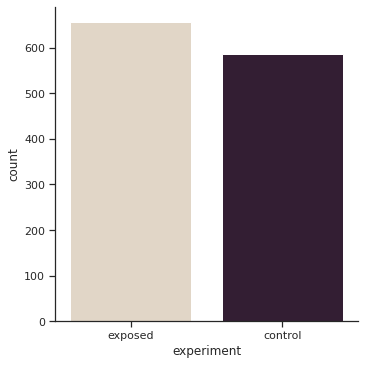

In [108]:
# data.info()
# Out of Total Users who responded, how many belongs the control and Exposed
categories = ["control", "exposed"]
for category in categories:
    print(f" {category} group has a total users of {resp_data[resp_data.experiment == category].experiment.count()}")


sns.catplot(x="experiment", kind="count", palette="ch:.25", data=resp_data)

Out of 1243 Users who responded, 586 users belongs to Control and 657 users belongs to Exposed group.

### Droping some Users that belongs to Exposed Group to make the number equal for both Exposed and Control

In [109]:
# Droping some of Exposed group users
resp_data = resp_data.drop(resp_data.query("experiment == 'exposed'").sample(frac=0.108).index)
# resp_data = resp_data.drop(resp_data.query("experiment == 'exposed'" and "yes == 0").sample(frac=0.027).index)
# resp_data = resp_data.drop(resp_data.query("experiment == 'exposed'" and "no == 1").sample(frac=0.027).index)
# resp_data = resp_data.drop(resp_data.query("experiment == 'exposed'" and "no == 0").sample(frac=0.027).index)
resp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172 entries, 0 to 1242
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   1172 non-null   object
 1   experiment   1172 non-null   object
 2   date         1172 non-null   object
 3   hour         1172 non-null   int64 
 4   device_make  1172 non-null   object
 5   platform_os  1172 non-null   int64 
 6   browser      1172 non-null   object
 7   yes          1172 non-null   int64 
 8   no           1172 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 91.6+ KB


 control group has a total users of 586
 exposed group has a total users of 586


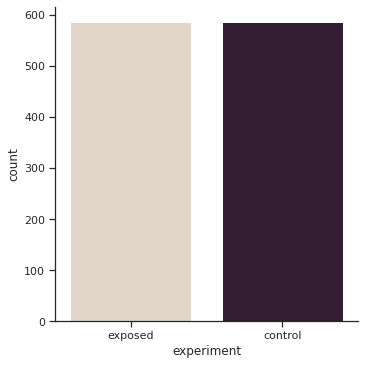

In [110]:
# Out of Total Users who responded, how many belongs the control and Exposed
categories = ["control", "exposed"]
for category in categories:
    print(f" {category} group has a total users of {resp_data[resp_data.experiment == category].experiment.count()}")


sns.catplot(x="experiment", kind="count", palette="ch:.25", data=resp_data)

### All Users are Uniques, there is no duplicates

### Exploration of Response against Date, time, device, and Browsers

['2020-07-10' '2020-07-07' '2020-07-05' '2020-07-03' '2020-07-09'
 '2020-07-04' '2020-07-06' '2020-07-08']
Users shown Ads against date, shown in First figure
Users who Responded to shown Ads against date, shown in second figure


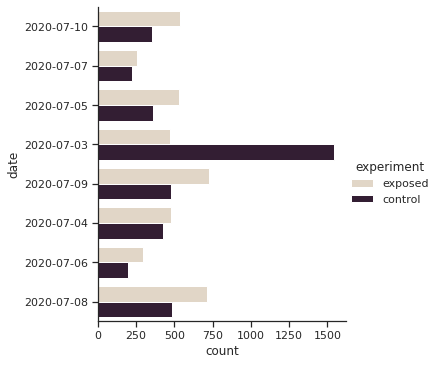

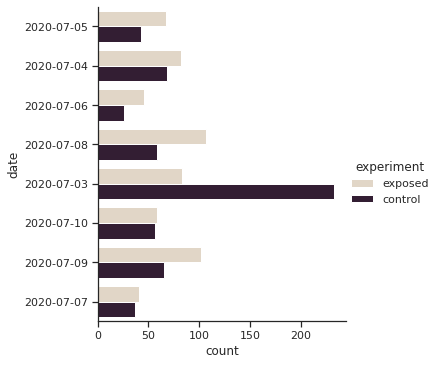

In [111]:
# Response Against Date
unique_date = data['date'].unique()
print(unique_date)
sns.set_theme(style="ticks", color_codes=True)
print("Users shown Ads against date, shown in First figure")
sns.catplot(y="date", kind="count", palette="ch:.25", hue="experiment",data=data)

print("Users who Responded to shown Ads against date, shown in second figure")
sns.catplot(y="date", kind="count", palette="ch:.25", hue="experiment",data=resp_data)

### Many users were shown or see the ad at 03rd, 08th and followed at 09th of july

### There is no significant relationship between Response and the Date the user(s) were shown the Ads, hence the graphs are almost symmetrical

### Data exploration against Time

[ 8 10  2 15  5  0 14 13  6 16  7 20  4 17  1 19 18  3 23 12  9 11 21 22]
Users shown Ads against hours, shown in First figure
Users who Responded to shown Ads against hour, shown in second figure


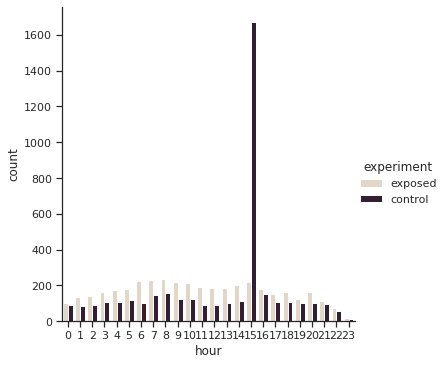

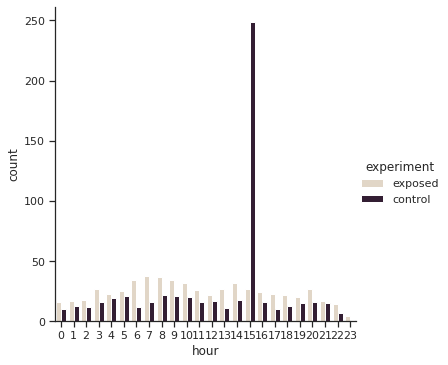

In [112]:
unique_hour = data['hour'].unique()
print(unique_hour)
sns.set_theme(style="ticks", color_codes=True)
print("Users shown Ads against hours, shown in First figure")
sns.catplot(x="hour", kind="count", palette="ch:.25", hue="experiment",data=data)

print("Users who Responded to shown Ads against hour, shown in second figure")
sns.catplot(x="hour", kind="count", palette="ch:.25", hue="experiment",data=resp_data)

### - Many users viewed or see the ad around 1500Hrs, followed by at 0800Hrs and 0700Hrs
### - There is no significant relationship between Response and the Hours the user(s) were shown the Ads, hence the graphs are almost symmetrical

### Data exploration against Device the User(s) uses

 There are 270 Uniques devices
List_Of_Device make of users shown the Ads
['Generic Smartphone', 'iPhone', 'Samsung SM-G960F', 'Samsung SM-G973F', 'Samsung SM-G950F', 'Samsung SM-G930F', 'Samsung SM-G975F', 'Samsung SM-A202F', 'Samsung SM-A405FN', 'Samsung SM-J330FN', 'Samsung SM-G965F', 'Samsung SM-A105FN', 'Nokia$2$3', 'Samsung SM-G935F', 'Nokia undefined$2$3']

List_Of_Device make of users who responded to Ads
['Generic Smartphone', 'Samsung SM-G960F', 'Samsung SM-G950F', 'Samsung SM-G973F', 'Samsung SM-A202F', 'iPhone', 'Samsung SM-G930F', 'Samsung SM-G975F', 'Samsung SM-A405FN', 'Samsung SM-A105FN', 'LG-$2', 'Samsung SM-G935F', 'Samsung SM-J330FN', 'Samsung SM-G970F', 'Samsung SM-A505FN']



Text(0.5, 1.0, 'List_Of_Top10_Device of User responded to Ads')

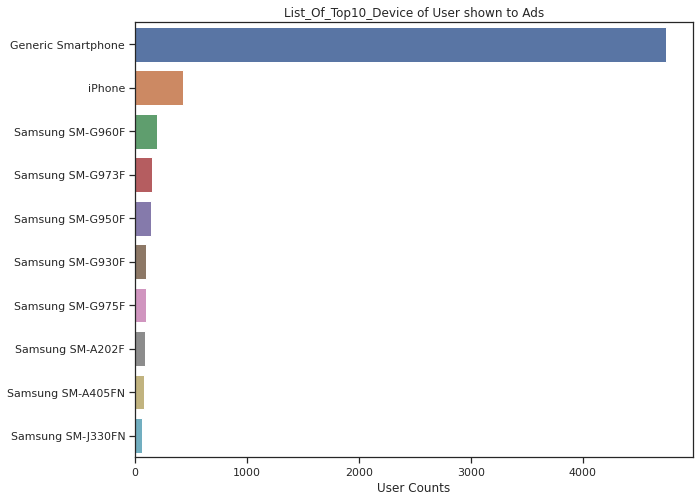

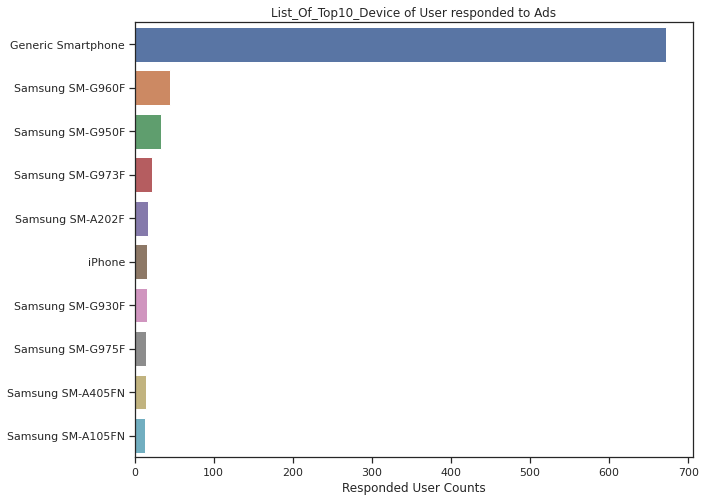

In [113]:
unique_devices = data['device_make'].unique()
print(f" There are {len(unique_devices)} Uniques devices")

def high_frequency_category(data, column):
    list_Of_Handset_In_Column=list(data[column].value_counts().index)
    top_category_column = data[column].value_counts()
    
    return list_Of_Handset_In_Column, top_category_column

list_Of_device, top_device = high_frequency_category(data, "device_make")
list_Of_device1, top_device1 = high_frequency_category(resp_data, "device_make")

print("List_Of_Device make of users shown the Ads")
print(list_Of_device[:15])
print("")
print("List_Of_Device make of users who responded to Ads")
print(list_Of_device1[:15])
print("")

plt.figure(figsize=(10,8))
sns.barplot(y = list_Of_device[:10], x = top_device[:10])
plt.xlabel('User Counts')
plt.title('List_Of_Top10_Device of User shown to Ads')

plt.figure(figsize=(10,8))
sns.barplot(y = list_Of_device1[:10], x = top_device1[:10])
plt.xlabel('Responded User Counts')
plt.title('List_Of_Top10_Device of User responded to Ads')

### Most Users who Responded are Generic Smartphone, and Samsung Users, as shown in the graphs! iPhone users responded less than Samsungs

### Data exploration against Browsers

 There are 15 Uniques browsers


Text(0.5, 1.0, 'List_Of_Top10_Browsers of User responded to Ads')

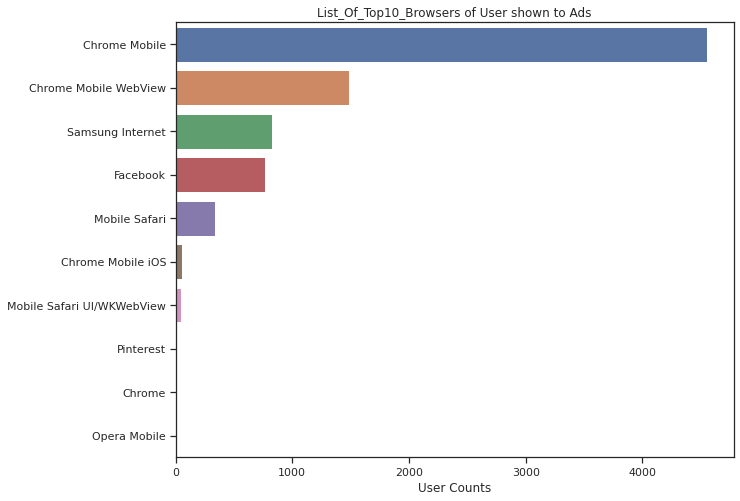

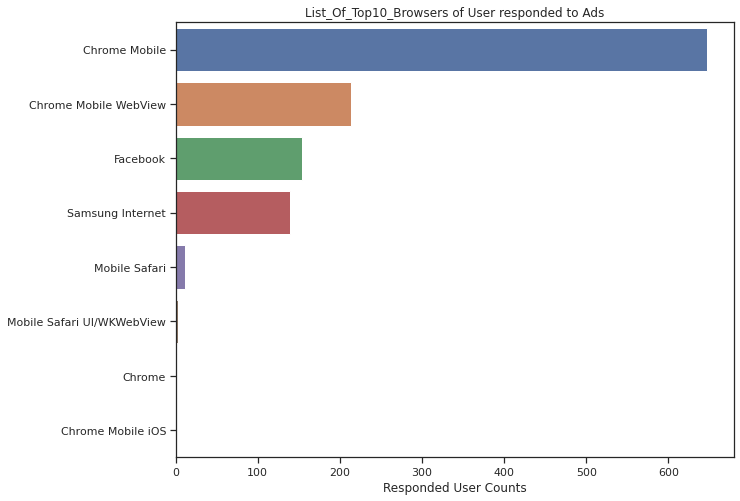

In [114]:
unique_browsers = data['browser'].unique()
print(f" There are {len(unique_browsers)} Uniques browsers")

list_Of_browsers, top_browsers = high_frequency_category(data, "browser")
list_Of_browsers1, top_browsers1 = high_frequency_category(resp_data, "browser")

plt.figure(figsize=(10,8))
sns.barplot(y = list_Of_browsers[:10], x = top_browsers[:10])
plt.xlabel('User Counts')
plt.title('List_Of_Top10_Browsers of User shown to Ads')

plt.figure(figsize=(10,8))
sns.barplot(y = list_Of_browsers1[:10], x = top_browsers1[:10])
plt.xlabel('Responded User Counts')
plt.title('List_Of_Top10_Browsers of User responded to Ads')

### Most of the Users who uses Chrome Mobile browser, saw  the ad, followed by Chrome Mobile Webview, and Facebook
### The graphs of users who was shown the ad, and those responded with respect to Browsers, are almost similar, meaning that the response almost doens't depend on browser type.

## 1.2.2 Performing hypothesis testing: applying the classical p-value based algorithm and the  sequential A/B testing algorithm

### Hypothesis Testing;
#### 1. Null Hypothesis(Ho) -> "There is no difference in brand awareness between the exposed and control groups in the current case"

#### 2. Alternate Hypothesis(Ha) -> "There is difference in brand awareness between the exposed and control groups in the current case"

Setting Parameters:
1. Alpha value = 0.05
2. Confidence interval = 0.95
3. Sample size = 1243, those who provided the feedback


In [32]:
# Importing statsmodels
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [115]:
control_results = resp_data[resp_data['experiment'] == 'control']['yes']
exposed_results = resp_data[resp_data['experiment'] == 'exposed']['yes']

### Statistics of Exposed and Control Group

In [116]:
# Calculating Statistics of the control and Exposed groups

conversion_rates = resp_data.groupby('experiment')['yes']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

### Judging by the statistics above, it does look like our exposed group design performed similarly, with our new design performing slightly better, at 48.5% vs. 45.1% conversion rate.


In [34]:
n_con = control_results.count()
n_exposed = exposed_results.count()
successes = [control_results.sum(), exposed_results.sum()]
nobs = [n_con, n_exposed]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.65
p-value: 0.518
ci 95% for control group: [0.410, 0.491]
ci 95% for treatment group: [0.431, 0.507]


## Conclusion
### The obtained p-value is way greater than the level of Significance,
### - Therefor, we can't reject the null Hypothesis. This shows the creative ad, didn't increse the brand awarenes as was expected to do